# Create classifier with reconstructed licit and illicit nodes

In [94]:
from src.modelNoPCA import Autoencoder
from src.data import Data

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
import pandas as pd

### Retrieve the used data for the Autoencoder training and remove it from the data to train the classifier. 

In [95]:
AE_data = pd.read_csv('../../../data/noPCA_AEData2.csv')

classesDF  = pd.read_csv('../../../data/elliptic_txs_classes.csv')
# Remove all nodes that have unknown class
classesDF = classesDF[classesDF['class'] != "unknown"]
# If class = 2, then map to 0, else map to 1
classesDF['class'] = classesDF['class'].map({'2': 0, '1': 1})


featuresDF = pd.read_csv('../../../data/elliptic_txs_features.csv')
# Change column names --> Column 1 is txId, Column 2 is timestep and the rest are unknown features
featuresDF.columns = ['txId', 'timestep'] + ['f' + str(i) for i in range(165)]
# Remove all edges that do not appear in classesDF
featuresDF = featuresDF[featuresDF['txId'].isin(classesDF['txId'])]
# Append the class to the featuresDF based on txID
featuresDF = featuresDF.merge(classesDF, on='txId')

# Move features 'class' to first column
cols = list(featuresDF.columns)
cols = cols[:1] + [cols[-1]] + cols[1:-1]
featuresDF = featuresDF[cols]

# Take featuresDF and remove from it all rows that appear in AE_data
featuresDF = featuresDF[~featuresDF['txId'].isin(AE_data['txId'])]

featuresDF.head(5)

,txId,class,timestep,f0,f1,f2,f3,f4,f5,f6,...,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164
9,232051089,0,1,-0.172914,-0.184668,-1.201369,-0.046932,-0.024025,-0.029140,-0.061584,...,-0.560956,-0.584179,1.039938,0.851388,0.018279,-0.068266,-0.093204,-0.068808,-0.120613,-0.119792
55,230674241,0,1,-0.007920,-0.184668,-1.201369,0.028105,-0.063725,0.054722,-0.061584,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
60,231995264,0,1,-0.172870,-0.158783,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.532262,-0.550539,-0.979074,-0.978556,0.018279,-0.029817,0.008288,0.031697,-1.760926,-1.760984
77,230681119,0,1,-0.109788,-0.184668,-1.201369,-0.046932,-0.043875,-0.029140,-0.061584,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
82,232415197,0,1,-0.168459,-0.184668,-1.201369,0.178180,-0.063725,0.138585,0.242712,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792


### Convert to vectors in order to fit the Classifier

In [96]:
vectors = featuresDF.iloc[:, 2:].values
labels = featuresDF.iloc[:, 1].values

X_train, X_test, y_train, y_test = train_test_split(vectors, labels, test_size=0.2, random_state=42)

### Create the classifier and train it

In [97]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [98]:
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       919
           1       0.99      0.96      0.97       899

    accuracy                           0.97      1818
   macro avg       0.97      0.97      0.97      1818
weighted avg       0.97      0.97      0.97      1818



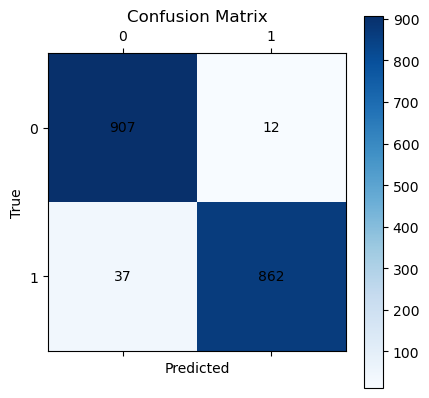

In [99]:
import matplotlib.pyplot as plt

# Plot confusion matrix and show number of instances
conf_matrix = confusion_matrix(y_test, y_pred)
plt.matshow(conf_matrix, cmap='Blues')
plt.colorbar()
for i in range(2):
    for j in range(2):
        plt.text(i, j, str(conf_matrix[j, i]), ha='center', va='center')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Now with the AutoEncoder

In [100]:
from sklearn.preprocessing import StandardScaler

In [101]:
# Normalize the data
scaler = StandardScaler()
scaler.fit(featuresDF.iloc[:, 2:])
featuresDF.iloc[:, 2:] = scaler.transform(featuresDF.iloc[:, 2:])

featuresDF.head(5)

,txId,class,timestep,f0,f1,f2,f3,f4,f5,f6,...,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164
9,232051089,0,-1.759135,-0.155663,-0.171871,-1.309096,-0.095750,-0.016985,-0.091519,-0.052369,...,-0.429171,-0.593319,1.163994,0.940402,0.19498,-0.075972,-0.100867,-0.053122,-0.028964,-0.029539
55,230674241,0,-1.759135,0.215348,-0.171871,-1.309096,-0.050505,-0.046921,-0.042667,-0.052369,...,-0.449687,-0.627229,0.218592,0.218461,0.19498,-0.106789,-0.156699,-0.100073,-0.028964,-0.029539
60,231995264,0,-1.759135,-0.155565,-0.155900,-1.309096,-0.140994,-0.031953,-0.140371,-0.052369,...,-0.392705,-0.554566,-1.225533,-1.225421,0.19498,-0.014337,0.048441,0.111204,-1.926402,-1.928531
77,230681119,0,-1.759135,-0.013716,-0.171871,-1.309096,-0.095750,-0.031953,-0.091519,-0.052369,...,-0.449687,-0.612696,0.218592,0.218461,0.19498,-0.106789,-0.156699,-0.100073,-0.028964,-0.029539
82,232415197,0,-1.759135,-0.145645,-0.171871,-1.309096,0.039983,-0.046921,0.006186,0.521859,...,-0.449687,-0.627229,0.218592,0.218461,0.19498,-0.106789,-0.156699,-0.100073,-0.028964,-0.029539


In [102]:
# vectors = featuresDF.iloc[:, 2:]
labels = featuresDF.iloc[:, 1].values

X_train, X_test, y_train, y_test = train_test_split(featuresDF, labels, test_size=0.2, random_state=42)

In [103]:
train_dataset = Data(X_train, y_train)
y_train = train_dataset.labels

test_dataset = Data(X_test, y_test)
y_test = test_dataset.labels

In [104]:
model = Autoencoder()
model.load_state_dict(torch.load('models/NoPCA_Autoencoder_secondRUN.pth'))
model.to('cuda')

model.eval()
with torch.no_grad():
    # Encode and decode the data
    reconstructed_train = model(train_dataset.vectors.to('cuda').unsqueeze(1)).cpu().numpy()
    reconstructed_test =  model(test_dataset.vectors.to('cuda').unsqueeze(1)).cpu().numpy()

# Train the classifier with reconstruction

In [109]:
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(reconstructed_train.squeeze(1), y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [106]:
reconstructed_test.shape

y_test.shape

(1818,)

In [107]:
y_pred = clf.predict(reconstructed_test.squeeze(1))

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       919
           1       0.98      0.92      0.95       899

    accuracy                           0.95      1818
   macro avg       0.95      0.95      0.95      1818
weighted avg       0.95      0.95      0.95      1818



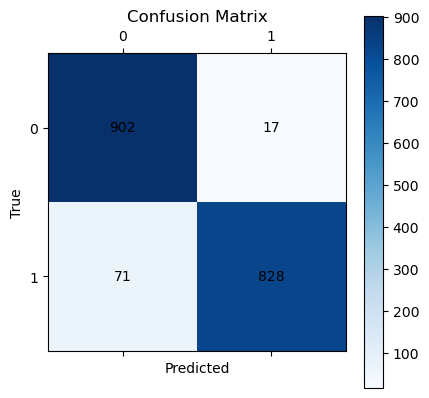

In [108]:
# Plot confusion matrix and show number of instances
conf_matrix = confusion_matrix(y_test, y_pred)
plt.matshow(conf_matrix, cmap='Blues')
plt.colorbar()
for i in range(2):
    for j in range(2):
        plt.text(i, j, str(conf_matrix[j, i]), ha='center', va='center')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()